In [303]:
import json
import random
from tqdm import tqdm
import numpy as np

from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

import torch

from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

# Что делать?
Где есть пометка # CODE писать код

[Полезный туториал](http://jalammar.github.io/illustrated-word2vec/)

# Загружаем данные
Они уже обработанные и токенизированные. Процесс можно посмотреть в тетрадке 1.1 Processing corpus

In [2]:
with open('data/processed_corpus.json', encoding='UTF-8') as f:
    corpus = json.load(f)

In [3]:
len(corpus)

100000

In [4]:
for text in corpus[:5]:
    print(' '.join(text))

второй UNK год окончательно разочаровать решить податься альфабанк
вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит
притом ситуация решиться участие течение сутки заявить
мой ##число летний жизнь это самый неповоротливый работник банк который видеть
везде написать вклад принимать очередь это


# CBOW

In [5]:
sample_text = corpus[1]

In [6]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом CBOW

In [7]:
sample_text[sample_text.index('денежный') : sample_text.index('либо')]

['денежный', 'средство', 'лицевой', 'счёт']

In [8]:
def cbow_split(tokens, window, pad_token='PAD'):
    
    splits = []
    
    # CODE
    padded = [pad_token] * window + tokens + [pad_token] * window

    for idx, token in enumerate(padded[window : -window]):
        splits.append((padded[idx : idx + window], padded[idx + window],
                       padded[idx + window + 1: idx + window + 1 + window]))
        
    return splits

In [9]:
splits = cbow_split(sample_text, window=2)

In [10]:
for sample in splits:
    print('Левый контекст:', sample[0])
    print('Центральное слово:', sample[1])
    print('Правый контекст:', sample[2], end='\n\n')

Левый контекст: ['PAD', 'PAD']
Центральное слово: вернуть
Правый контекст: ['денежный', 'средство']

Левый контекст: ['PAD', 'вернуть']
Центральное слово: денежный
Правый контекст: ['средство', 'лицевой']

Левый контекст: ['вернуть', 'денежный']
Центральное слово: средство
Правый контекст: ['лицевой', 'счёт']

Левый контекст: ['денежный', 'средство']
Центральное слово: лицевой
Правый контекст: ['счёт', 'либо']

Левый контекст: ['средство', 'лицевой']
Центральное слово: счёт
Правый контекст: ['либо', 'зачесть']

Левый контекст: ['лицевой', 'счёт']
Центральное слово: либо
Правый контекст: ['зачесть', 'счёт']

Левый контекст: ['счёт', 'либо']
Центральное слово: зачесть
Правый контекст: ['счёт', 'погашение']

Левый контекст: ['либо', 'зачесть']
Центральное слово: счёт
Правый контекст: ['погашение', 'кредит']

Левый контекст: ['зачесть', 'счёт']
Центральное слово: погашение
Правый контекст: ['кредит', 'PAD']

Левый контекст: ['счёт', 'погашение']
Центральное слово: кредит
Правый контекст: [

In [11]:
splits

[(['PAD', 'PAD'], 'вернуть', ['денежный', 'средство']),
 (['PAD', 'вернуть'], 'денежный', ['средство', 'лицевой']),
 (['вернуть', 'денежный'], 'средство', ['лицевой', 'счёт']),
 (['денежный', 'средство'], 'лицевой', ['счёт', 'либо']),
 (['средство', 'лицевой'], 'счёт', ['либо', 'зачесть']),
 (['лицевой', 'счёт'], 'либо', ['зачесть', 'счёт']),
 (['счёт', 'либо'], 'зачесть', ['счёт', 'погашение']),
 (['либо', 'зачесть'], 'счёт', ['погашение', 'кредит']),
 (['зачесть', 'счёт'], 'погашение', ['кредит', 'PAD']),
 (['счёт', 'погашение'], 'кредит', ['PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD'], 'вопрос', ['почему', 'например']),
 (['PAD', 'вопрос'], 'почему', ['например', 'китайский']),
 (['вопрос', 'почему'], 'например', ['китайский', 'японский']),
 (['почему', 'например'], 'китайский', ['японский', 'UNK']),
 (['например', 'китайский'], 'японский', ['UNK', 'PAD']),
 (['китайский', 'японский'], 'UNK', ['PAD', 'PAD'])]
```

In [12]:
cbow_split(sample_text, window=3)

[(['PAD', 'PAD', 'PAD'], 'вернуть', ['денежный', 'средство', 'лицевой']),
 (['PAD', 'PAD', 'вернуть'], 'денежный', ['средство', 'лицевой', 'счёт']),
 (['PAD', 'вернуть', 'денежный'], 'средство', ['лицевой', 'счёт', 'либо']),
 (['вернуть', 'денежный', 'средство'], 'лицевой', ['счёт', 'либо', 'зачесть']),
 (['денежный', 'средство', 'лицевой'], 'счёт', ['либо', 'зачесть', 'счёт']),
 (['средство', 'лицевой', 'счёт'], 'либо', ['зачесть', 'счёт', 'погашение']),
 (['лицевой', 'счёт', 'либо'], 'зачесть', ['счёт', 'погашение', 'кредит']),
 (['счёт', 'либо', 'зачесть'], 'счёт', ['погашение', 'кредит', 'PAD']),
 (['либо', 'зачесть', 'счёт'], 'погашение', ['кредит', 'PAD', 'PAD']),
 (['зачесть', 'счёт', 'погашение'], 'кредит', ['PAD', 'PAD', 'PAD'])]

# Expected

```python
[(['PAD', 'PAD', 'PAD'], 'вопрос', ['почему', 'например', 'китайский']),
 (['PAD', 'PAD', 'вопрос'], 'почему', ['например', 'китайский', 'японский']),
 (['PAD', 'вопрос', 'почему'], 'например', ['китайский', 'японский', 'UNK']),
 (['вопрос', 'почему', 'например'], 'китайский', ['японский', 'UNK', 'PAD']),
 (['почему', 'например', 'китайский'], 'японский', ['UNK', 'PAD', 'PAD']),
 (['например', 'китайский', 'японский'], 'UNK', ['PAD', 'PAD', 'PAD'])]
```

# Skipgram

In [13]:
' '.join(sample_text)

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

# Реализуйте разделение предложения на примеры методом Skipgram

In [14]:
def skipgram_split(tokens, window):
    
    splits = []
    
    # CODE
    
    # как для cbow, но пады игнорируются
    padded = ['PAD'] * window + tokens + ['PAD'] * window

    for idx, token in enumerate(padded[window:-window]):
        for n in range(1, window+1):
            if padded[idx + window - n] != 'PAD':
                splits.append((padded[idx + window - n], token))
            if padded[idx + window + n] != 'PAD':
                splits.append((padded[idx + window + n], token))
    
    return splits

In [15]:
splits = skipgram_split(sample_text, window=2)

In [16]:
'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

'вернуть денежный средство лицевой счёт либо зачесть счёт погашение кредит'

In [17]:
skipgram_split(sample_text, window=2)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('вернуть', 'средство'),
 ('счёт', 'средство'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('денежный', 'лицевой'),
 ('либо', 'лицевой'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('средство', 'счёт'),
 ('зачесть', 'счёт'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('либо', 'счёт'),
 ('кредит', 'счёт'),
 ('счёт', 'погашение'),
 ('кредит', 'погашение'),
 ('зачесть', 'погашение'),
 ('погашение', 'кредит'),
 ('счёт', 'кредит')]

In [18]:
for sample in splits:
    print('Контекст:', sample[0])
    print('Центральное слово:', sample[1], end='\n\n')

Контекст: денежный
Центральное слово: вернуть

Контекст: средство
Центральное слово: вернуть

Контекст: вернуть
Центральное слово: денежный

Контекст: средство
Центральное слово: денежный

Контекст: лицевой
Центральное слово: денежный

Контекст: денежный
Центральное слово: средство

Контекст: лицевой
Центральное слово: средство

Контекст: вернуть
Центральное слово: средство

Контекст: счёт
Центральное слово: средство

Контекст: средство
Центральное слово: лицевой

Контекст: счёт
Центральное слово: лицевой

Контекст: денежный
Центральное слово: лицевой

Контекст: либо
Центральное слово: лицевой

Контекст: лицевой
Центральное слово: счёт

Контекст: либо
Центральное слово: счёт

Контекст: средство
Центральное слово: счёт

Контекст: зачесть
Центральное слово: счёт

Контекст: счёт
Центральное слово: либо

Контекст: зачесть
Центральное слово: либо

Контекст: лицевой
Центральное слово: либо

Контекст: счёт
Центральное слово: либо

Контекст: либо
Центральное слово: зачесть

Контекст: счёт
Цент

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [19]:
skipgram_split(sample_text, window=3)

[('денежный', 'вернуть'),
 ('средство', 'вернуть'),
 ('лицевой', 'вернуть'),
 ('вернуть', 'денежный'),
 ('средство', 'денежный'),
 ('лицевой', 'денежный'),
 ('счёт', 'денежный'),
 ('денежный', 'средство'),
 ('лицевой', 'средство'),
 ('вернуть', 'средство'),
 ('счёт', 'средство'),
 ('либо', 'средство'),
 ('средство', 'лицевой'),
 ('счёт', 'лицевой'),
 ('денежный', 'лицевой'),
 ('либо', 'лицевой'),
 ('вернуть', 'лицевой'),
 ('зачесть', 'лицевой'),
 ('лицевой', 'счёт'),
 ('либо', 'счёт'),
 ('средство', 'счёт'),
 ('зачесть', 'счёт'),
 ('денежный', 'счёт'),
 ('счёт', 'счёт'),
 ('счёт', 'либо'),
 ('зачесть', 'либо'),
 ('лицевой', 'либо'),
 ('счёт', 'либо'),
 ('средство', 'либо'),
 ('погашение', 'либо'),
 ('либо', 'зачесть'),
 ('счёт', 'зачесть'),
 ('счёт', 'зачесть'),
 ('погашение', 'зачесть'),
 ('лицевой', 'зачесть'),
 ('кредит', 'зачесть'),
 ('зачесть', 'счёт'),
 ('погашение', 'счёт'),
 ('либо', 'счёт'),
 ('кредит', 'счёт'),
 ('счёт', 'счёт'),
 ('счёт', 'погашение'),
 ('кредит', 'погашение

# Expected

```python
[('почему', 'вопрос'),
 ('например', 'вопрос'),
 ('китайский', 'вопрос'),
 ('вопрос', 'почему'),
 ('например', 'почему'),
 ('китайский', 'почему'),
 ('японский', 'почему'),
 ('вопрос', 'например'),
 ('почему', 'например'),
 ('китайский', 'например'),
 ('японский', 'например'),
 ('UNK', 'например'),
 ('вопрос', 'китайский'),
 ('почему', 'китайский'),
 ('например', 'китайский'),
 ('японский', 'китайский'),
 ('UNK', 'китайский'),
 ('почему', 'японский'),
 ('например', 'японский'),
 ('китайский', 'японский'),
 ('UNK', 'японский'),
 ('например', 'UNK'),
 ('китайский', 'UNK'),
 ('японский', 'UNK')]
```

In [20]:
word2index = {}

for text in corpus:
    for token in text:
        if token not in word2index:
            word2index[token] = len(word2index)

In [250]:
len(word2index)

13076

In [22]:
word2index['UNK']

1

In [23]:
[word2index[tok] if tok in word2index else word2index['UNK'] for tok in 'мама мыть рама'.split()]

[1282, 8436, 1]

# Torch Dataset
В торче есть очень удобная читалка данных

In [24]:
from torch.utils.data import Dataset, DataLoader

In [25]:
# игрушечный датасет
# 121535 примера, 4 фичи, 3 класса
some_data_x = np.random.rand(121535, 4)
some_data_y = np.random.randint(3, size=(121535,))

In [26]:
# соверешенно игрушечный, просто цифры
some_data_x[:10]

array([[0.28790066, 0.24628027, 0.03071726, 0.77897654],
       [0.54635786, 0.89602618, 0.83997681, 0.51520239],
       [0.45309997, 0.13744957, 0.92628404, 0.48693649],
       [0.35075441, 0.16678144, 0.92354715, 0.49473846],
       [0.23918332, 0.86925903, 0.72293529, 0.90545415],
       [0.82097677, 0.25924789, 0.17185125, 0.68252761],
       [0.20076866, 0.78122411, 0.80893351, 0.55006336],
       [0.39705778, 0.85289832, 0.46766103, 0.17743459],
       [0.28150492, 0.03001495, 0.75316648, 0.71554864],
       [0.5757087 , 0.55273981, 0.3228647 , 0.06846728]])

In [27]:
some_data_y

array([2, 2, 1, ..., 1, 0, 0])

In [28]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        return self.data_x[idx], self.data_y[idx]

In [29]:
some_dataset = ToyDataset(some_data_x, some_data_y)

In [30]:
some_dataset[5], some_dataset[467]

((array([0.82097677, 0.25924789, 0.17185125, 0.68252761]), 2),
 (array([0.819421  , 0.47315301, 0.174272  , 0.48504426]), 0))

In [31]:
some_loader = DataLoader(some_dataset, batch_size=16, shuffle=True)

In [32]:
for x, y in some_loader:
    break
    
len(x), x

(16,
 tensor([[0.6368, 0.0036, 0.4951, 0.4882],
         [0.4507, 0.2940, 0.2759, 0.6021],
         [0.1708, 0.3699, 0.3392, 0.2875],
         [0.3049, 0.4604, 0.4829, 0.0173],
         [0.7668, 0.6230, 0.5003, 0.3541],
         [0.0723, 0.8370, 0.4944, 0.3922],
         [0.9449, 0.0924, 0.9379, 0.6524],
         [0.8920, 0.4095, 0.2718, 0.3522],
         [0.5870, 0.4806, 0.4283, 0.1536],
         [0.6765, 0.4999, 0.1910, 0.3087],
         [0.0260, 0.7828, 0.4141, 0.0710],
         [0.3670, 0.1555, 0.2665, 0.3327],
         [0.7066, 0.2550, 0.3532, 0.7247],
         [0.8363, 0.1557, 0.4316, 0.3351],
         [0.6025, 0.5823, 0.5707, 0.2996],
         [0.1072, 0.6481, 0.8406, 0.0932]], dtype=torch.float64))

In [33]:
for x, y in some_loader:
    pass

len(x)

15

In [34]:
# почему 13?
# потому что количество наших данных нацело не делится на 16
# и поэтому последний батч меньше 16-ти
len(some_dataset) % 16

15

# А зачем?

In [35]:
class ToyDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        
        super().__init__()
        
        self.data_x = data_x
        self.data_y = data_y
        
    def __len__(self):
        
        # Нужно обязательно определить эту функцию
        # Должна возвращать размер датасета
        
        return len(self.data_x)
    
    @staticmethod
    def add_pow_features(x, n=2):
        
        return np.concatenate([x, x ** n]) 
    
    @staticmethod
    def add_log_features(x):
        
        return np.concatenate([x, np.log(x)]) 
    
    def __getitem__(self, idx):
        
        # Еще нужно определить этот метод
        # То есть как мы будем доставать наши данные по индексу
        
        x = self.data_x[idx]
        
        # внутри датасета мы можем делать все что угодно с нашими данными
        # например выше определим функции, которые добавляют степенные фичи
        x = self.add_pow_features(x, n=2)
        x = self.add_pow_features(x, n=3)
        # и еще возьмем логарифмические фичи
        x = self.add_log_features(x)
        
        y = self.data_y[idx]
        
        return x, y

In [36]:
toy_dataset = ToyDataset(some_data_x, some_data_y)

In [37]:
toy_loader = DataLoader(dataset=toy_dataset, batch_size=128)

In [38]:
for x, y in toy_loader:
    break

In [39]:
x.shape

torch.Size([128, 32])

In [40]:
# заметим, что мы сразу получаем торчовый формат данных
x

tensor([[  0.2879,   0.2463,   0.0307,  ...,  -8.4077, -20.8976,  -1.4986],
        [  0.5464,   0.8960,   0.8400,  ...,  -0.6587,  -1.0463,  -3.9792],
        [  0.4531,   0.1374,   0.9263,  ..., -11.9070,  -0.4594,  -4.3177],
        ...,
        [  0.8832,   0.6006,   0.4071,  ...,  -3.0586,  -5.3927, -21.6285],
        [  0.8562,   0.6573,   0.7206,  ...,  -2.5179,  -1.9657,  -0.2071],
        [  0.5966,   0.9392,   0.1472,  ...,  -0.3762, -11.4966,  -1.8723]],
       dtype=torch.float64)

In [41]:
y

tensor([2, 2, 1, 1, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 1,
        1, 1, 2, 1, 1, 1, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 1, 2, 0, 0, 2, 1,
        2, 0, 1, 0, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 2, 2, 2, 0, 1, 1, 1, 2,
        2, 1, 1, 2, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 0, 2, 0, 0, 1, 2, 0, 2, 1,
        0, 2, 2, 0, 0, 0, 0, 2, 1, 0, 2, 2, 1, 1, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0,
        0, 1, 1, 0, 1, 0, 2, 0], dtype=torch.int32)

# Если вы ничего здесь не понимаете, то вернитесь в конец первой домашки, там все объясняется

In [42]:
model = torch.nn.Sequential(torch.nn.Linear(32, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 8),
                            torch.nn.ReLU(),
                            torch.nn.Linear(8, 3))

criterion = torch.nn.CrossEntropyLoss()

In [43]:
with torch.no_grad():

    prediction = model(x.float())

    loss = criterion(prediction, y.long())
    
loss.item()

1.1639823913574219

# Боевые датасеты

In [44]:
class CBOWDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 pad_token='PAD',
                 collect_verbose=True):

        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.pad_token = pad_token
        self.pad_index = len(self.word2index)

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()

    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):

        splits = []

        for n in range(len(tokenized_text)):
            left_context = tokenized_text[np.maximum(n - self.window, 0):n]
            left_context = ([self.pad_index] * (self.window - len(left_context))) + left_context

            central_word = tokenized_text[n]

            right_context = tokenized_text[n + 1:n + self.window + 1]
            right_context = right_context + ([self.pad_index] * (self.window - len(right_context)))

            splits.append((left_context + right_context, central_word))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            cbow_examples = self._split_function(indexed_text)

            self.data.extend(cbow_examples)

    def __getitem__(self, idx):

        context, central_word = self.data[idx]

        context = torch.Tensor(context).long()

        return context, central_word

# Мы будем учить модель Skipgram
Реализуйте читалку данных

In [45]:
class SkipgramDataset(Dataset):

    def __init__(self,
                 corpus,
                 word2index,
                 window=2,
                 unk_token='UNK',
                 collect_verbose=True):
        
        self.corpus = corpus
        self.word2index = word2index
        self.index2word = {value: key for key, value in self.word2index.items()}
        self.window = window

        self.unk_token = unk_token
        self.unk_index = self.word2index[self.unk_token]

        self.collect_verbose = collect_verbose

        self.data = []

        self.collect_data()


    def __len__(self):

        return len(self.data)

    def _split_function(self, tokenized_text):
        
        # CODE
        
        # вставить здесь функцию, которые вы писали раньше

        splits = []
        
        padded = ['PAD'] * self.window + tokenized_text + ['PAD'] * self.window

        for idx, token in enumerate(padded[self.window:-self.window]):
            for n in range(1, self.window+1):
                if padded[idx + self.window - n] != 'PAD':
                    splits.append((padded[idx + self.window - n], token))
                if padded[idx + self.window + n] != 'PAD':
                    splits.append((padded[idx + self.window + n], token))

        return splits

    def indexing(self, tokenized_text):

        return [self.word2index[token] if token in self.word2index else self.unk_index for token in tokenized_text]

    def collect_data(self):

        corpus = tqdm(self.corpus, disable=not self.collect_verbose)

        for tokenized_text in corpus:
            indexed_text = self.indexing(tokenized_text)
            skipgram_examples = self._split_function(indexed_text)

            self.data.extend(skipgram_examples)

    def __getitem__(self, idx):
        
        # CODE
        
        context, central_word = self.data[idx]

        # context = torch.Tensor(context).long()

        return context, central_word

In [46]:
# можете положить SkipgramDataset в отдельный файлик, например word2vec_utils и относительным импортом достать его 
#from .word2vec_utils import SkipgramDataset

In [47]:
dataset = SkipgramDataset(corpus, word2index)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 39022.63it/s]


In [48]:
BATCH_SIZE = 512

In [49]:
dataset_loader = DataLoader(dataset, shuffle=True, batch_size=BATCH_SIZE)

In [50]:
for x, y in dataset_loader:
    break

In [51]:
x[:5]

tensor([ 25,  61,  25, 865, 414])

In [52]:
y[:5]

tensor([ 423, 2062, 5669,   48, 2230])

In [53]:
x.shape, y.shape

(torch.Size([512]), torch.Size([512]))

In [54]:
class CBOW(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, pad_index):
        
        super().__init__()
        
        if pad_index > 0:
            vocab_size += 1
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim,
                                               padding_idx=pad_index)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
    def forward(self, x):
        
        x = self.in_embedding(x).sum(dim=-2)
        x = self.out_embedding(x)
        
        return x

# Мы будем учить модель Skipgram
Реализуйте ее

In [55]:
# CODE
class SkipGram(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_dim):
        
        super().__init__()
        
        self.in_embedding = torch.nn.Embedding(num_embeddings=vocab_size, 
                                               embedding_dim=embedding_dim)
        
        self.out_embedding = torch.nn.Linear(in_features=embedding_dim,
                                             out_features=vocab_size, bias=False)
        
        
    def forward(self, x):
        
        x = self.in_embedding(x)
        x = self.out_embedding(x)
        
        return x

In [56]:
#from word2vec_utils import SkipGram

In [57]:
# размерность эмбеддинга
# маленькая, чтобы мы могли недолго поучить ворд2век и увидеть результаты
EMBEDDING_DIM = 20

In [58]:
model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [59]:
with torch.no_grad():
    pred = model(x)

pred.shape

torch.Size([512, 13076])

In [60]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# aka loss function
criterion = torch.nn.CrossEntropyLoss()

# Допишите обучалку

In [61]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE
            prediction = model(x)
            
            loss = criterion(prediction, y) # CODE
            
            # CODE
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|███████████████████████████████████████████████████| 2983124/2983124 [19:11<00:00, 2591.57it/s, loss=7.1]


In [74]:
torch.save(model, 'hw2_model.pt')

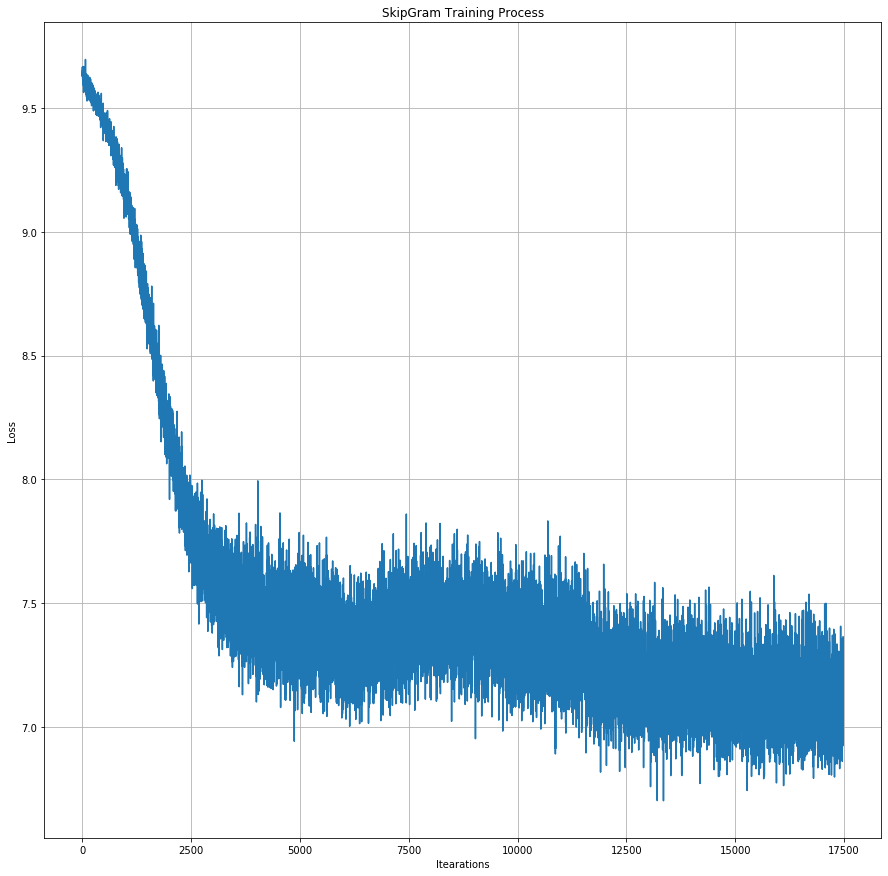

In [62]:
plt.title('SkipGram Training Process')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [63]:
# проверка, что хоть что-то выучилось
assert np.mean(losses[-1000:]) < 7.5

In [251]:
embedding_matrix = model.in_embedding.weight.detach()

In [252]:
def cos_sim(embedding_matrix, token2id, word1, word2):
    
    i1 = token2id[word1]
    i2 = token2id[word2]
    
    v1, v2 = embedding_matrix[i1], embedding_matrix[i2]
    
    v1_n = v1.div(v1.norm(keepdim=True))
    v2_n = v2.div(v2.norm(keepdim=True))
    
    similarity = torch.dot(v1_n, v2_n).item()
    
    return similarity

# Косинусная близость
От 0 до 1, где 0 - вектора абсолютно разные, где 1 - идентичные.

In [241]:
cos_sim(embedding_matrix, word2index, 'день', 'месяц')

0.2692881226539612

In [242]:
cos_sim(embedding_matrix, word2index, 'минута', 'месяц')

0.5195519924163818

In [243]:
cos_sim(embedding_matrix, word2index, 'сотрудник', 'сотрудница')

-0.16111688315868378

In [244]:
cos_sim(embedding_matrix, word2index, 'вклад', 'перевод')

0.04515024274587631

In [245]:
random_word = random.choice(list(word2index.keys()))
sim = cos_sim(embedding_matrix, word2index, 'день', random_word)
'Косинусная близость слова "день" к случайному выбраному слову "{}" равна {:.3f}'.format(random_word, sim)

'Косинусная близость слова "день" к случайному выбраному слову "жалюзи" равна 0.195'

In [71]:
freq = {}

for text in corpus:
    for token in text:
        if token in freq:
            freq[token] += 1
        else:
            freq[token] = 1

In [72]:
sorted_freq = [(k, freq[k]) for k in sorted(freq, key=freq.get, reverse=True)]
top_sorted_freq = sorted_freq[0:200]

In [73]:
tsne = TSNE(n_components=2, init='pca', random_state=42, verbose=2)
reduced = tsne.fit_transform(embedding_matrix)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13076 samples in 0.035s...
[t-SNE] Computed neighbors for 13076 samples in 10.075s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13076
[t-SNE] Computed conditional probabilities for sample 2000 / 13076
[t-SNE] Computed conditional probabilities for sample 3000 / 13076
[t-SNE] Computed conditional probabilities for sample 4000 / 13076
[t-SNE] Computed conditional probabilities for sample 5000 / 13076
[t-SNE] Computed conditional probabilities for sample 6000 / 13076
[t-SNE] Computed conditional probabilities for sample 7000 / 13076
[t-SNE] Computed conditional probabilities for sample 8000 / 13076
[t-SNE] Computed conditional probabilities for sample 9000 / 13076
[t-SNE] Computed conditional probabilities for sample 10000 / 13076
[t-SNE] Computed conditional probabilities for sample 11000 / 13076
[t-SNE] Computed conditional probabilities for sample 12000 / 13076
[t-SNE] Computed conditional probabilities for sa

C:\Users\User\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\User\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] Iteration 50: error = 96.9113464, gradient norm = 0.0000946 (50 iterations in 21.490s)
[t-SNE] Iteration 100: error = 96.9237823, gradient norm = 0.0000112 (50 iterations in 12.665s)
[t-SNE] Iteration 150: error = 96.9237823, gradient norm = 0.0000102 (50 iterations in 8.130s)
[t-SNE] Iteration 200: error = 96.9237747, gradient norm = 0.0000121 (50 iterations in 6.855s)
[t-SNE] Iteration 250: error = 96.9237747, gradient norm = 0.0000098 (50 iterations in 7.414s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.923775


C:\Users\User\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
C:\Users\User\Anaconda3\lib\site-packages\sklearn\manifold\t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  best_error = np.finfo(np.float).max


[t-SNE] Iteration 300: error = 4.7492933, gradient norm = 0.0010932 (50 iterations in 9.989s)
[t-SNE] Iteration 350: error = 4.2884521, gradient norm = 0.0005833 (50 iterations in 15.674s)
[t-SNE] Iteration 400: error = 4.1566663, gradient norm = 0.0003275 (50 iterations in 10.394s)
[t-SNE] Iteration 450: error = 4.0724292, gradient norm = 0.0002339 (50 iterations in 9.585s)
[t-SNE] Iteration 500: error = 4.0136728, gradient norm = 0.0001669 (50 iterations in 11.066s)
[t-SNE] Iteration 550: error = 3.9707942, gradient norm = 0.0001308 (50 iterations in 11.184s)
[t-SNE] Iteration 600: error = 3.9356976, gradient norm = 0.0001071 (50 iterations in 11.996s)
[t-SNE] Iteration 650: error = 3.9071131, gradient norm = 0.0000910 (50 iterations in 11.783s)
[t-SNE] Iteration 700: error = 3.8829706, gradient norm = 0.0000769 (50 iterations in 14.595s)
[t-SNE] Iteration 750: error = 3.8622386, gradient norm = 0.0000684 (50 iterations in 16.132s)
[t-SNE] Iteration 800: error = 3.8446722, gradient n

In [75]:
top_words = [a for a,_ in top_sorted_freq]

In [76]:
inds = [word2index[word] for word in top_words]
x_coords = [coords[0] for coords in reduced[inds]]
y_coords = [coords[1] for coords in reduced[inds]]

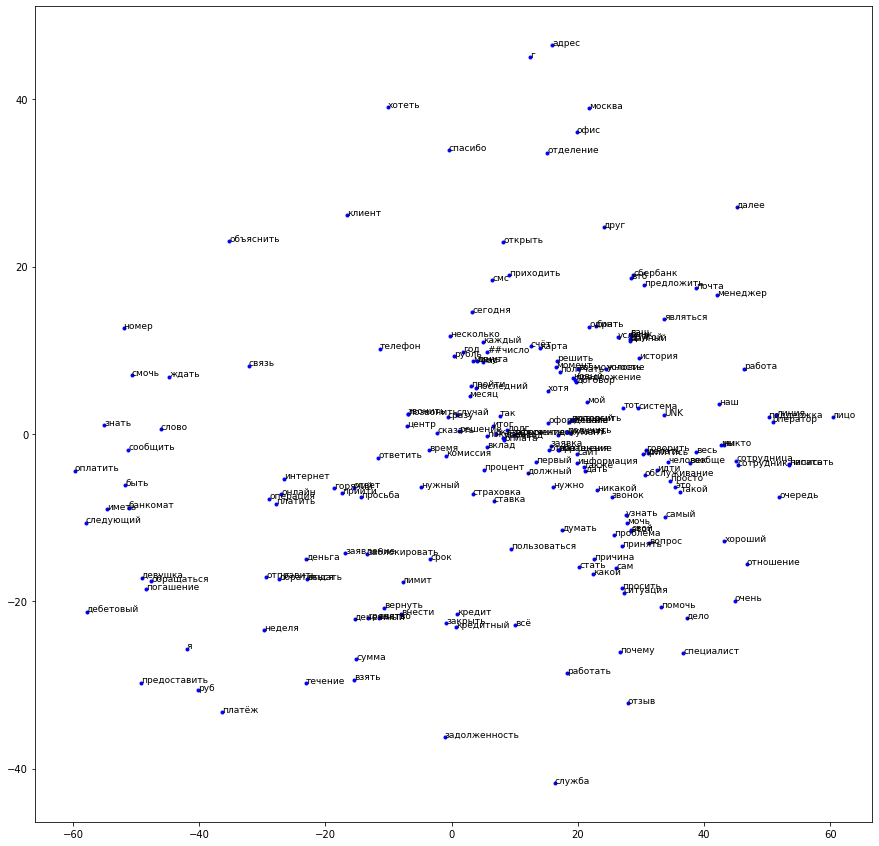

In [77]:
for (x, y, word) in zip(x_coords, y_coords, top_words):
    plt.scatter(x, y, marker='.', color='blue')
    plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.show()

# Оценка
1. Вы добрались сюда и все работает, значит уже получили 7 баллов.
2. 8 баллов - Взяли корпус для оценка качества эмбеддингов [здесь](https://rusvectores.org/static/testsets/ru_simlex965_tagged.tsv). Описание к нему [здесь](https://arxiv.org/pdf/1801.06407.pdf). Его английская версия для понимания, того что же это такое [тут](https://fh295.github.io/simlex.html). Если в кратце - он похож а гугл аналогии, просто иначе составлен. Определили качество своих эмбеддингов. Как качество измерить? Можете все значения отнормировать (привести к 1) и затем считать MSE между тем что у вас и что в оригинале.
3. 9 баллов - Поставили эксперименты, поменяли любые параметры, хоть корпус увеличили или как то почистили. Показали метрики до и после. После должно быть лучше, иначе это все еще 8 баллов.
4. 10 баллов - удивили своим подходом (или просто удивили) пока делили на 9 баллов

### Оценка эмбеддингов

In [246]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [253]:
df = pd.read_csv('data/ru_simlex965_tagged.tsv', delimiter='\t')
df.head(5)

,# Word1,Word2,Average Score
0,авария_NOUN,бедствие_NOUN,6.15
1,август_NOUN,месяц_NOUN,2.85
2,авиация_NOUN,полет_NOUN,6.77
3,автомобиль_NOUN,гудок_NOUN,1.85
4,автомобиль_NOUN,автострада_NOUN,1.23


In [254]:
df['# Word1'] = df['# Word1'].apply(lambda x: x.split('_')[0])
df['Word2'] = df['Word2'].apply(lambda x: x.split('_')[0])
df.head(5)

,# Word1,Word2,Average Score
0,авария,бедствие,6.15
1,август,месяц,2.85
2,авиация,полет,6.77
3,автомобиль,гудок,1.85
4,автомобиль,автострада,1.23


In [255]:
scaler = MinMaxScaler()
df[['Normed Score']] = scaler.fit_transform(df[['Average Score']])
df.head(5)

,# Word1,Word2,Average Score,Normed Score
0,авария,бедствие,6.15,0.615
1,август,месяц,2.85,0.285
2,авиация,полет,6.77,0.677
3,автомобиль,гудок,1.85,0.185
4,автомобиль,автострада,1.23,0.123


In [256]:
vocab = word2index.keys()

In [257]:
emb_scores = []
for idx, row in df.iterrows():
    if row['# Word1'] in vocab and row['Word2'] in vocab:
        sim = cos_sim(embedding_matrix, word2index, row['# Word1'], row['Word2'])
        emb_scores.append(sim)
    else:
        df.drop([idx], inplace=True)

In [258]:
df['Embedding Score'] = emb_scores

In [259]:
df[['Normed Embedding']] = scaler.fit_transform(df[['Embedding Score']])

In [260]:
len(df)

498

In [261]:
df.head(5)

,# Word1,Word2,Average Score,Normed Score,Embedding Score,Normed Embedding
1,август,месяц,2.85,0.285,0.474598,0.830700
3,автомобиль,гудок,1.85,0.185,-0.128106,0.398491
5,автомобиль,такси,4.15,0.415,-0.011401,0.482182
7,автомобиль,велосипед,1.38,0.138,0.187274,0.624655
9,автомобиль,мост,1.15,0.115,-0.185354,0.357438


In [262]:
mse_before = mean_squared_error(df['Normed Score'], df['Normed Embedding'])
mse_before

0.18862689294612311

### Улучшить эмбеддинги
Для начала посмотрим, где вообще большие расхождения между золотым стандартом и результатами модели. Пусть большим расхождением будет считаться разница от 0,6:

In [263]:
# здесь близость есть, но она не определена - false negative:

df.loc[df['Normed Score'] - df['Normed Embedding'] > 0.6]

,# Word1,Word2,Average Score,Normed Score,Embedding Score,Normed Embedding
97,внимание,интерес,7.08,0.708,-0.553743,0.093260
239,задание,задача,8.85,0.885,-0.331202,0.252848
491,область,регион,9.08,0.908,-0.372339,0.223348
782,создавать,делать,8.31,0.831,-0.442194,0.173253


In [264]:
# здесь близости мало или нет, но она ложно определена - false positive

df.loc[df['Normed Embedding'] - df['Normed Score'] > 0.6]

,# Word1,Word2,Average Score,Normed Score,Embedding Score,Normed Embedding
28,арифметика,ритм,0.23,0.023,0.697003,0.990190
65,брать,доставлять,1.15,0.115,0.342776,0.736168
103,воровать,покупать,0.00,0.000,0.384906,0.766380
115,выходной,неделя,2.92,0.292,0.691907,0.986535
121,глава,выбор,0.85,0.085,0.325658,0.723893
...,...,...,...,...,...,...
920,цель,поиск,0.62,0.062,0.368828,0.754850
922,цент,размер,0.69,0.069,0.625817,0.939141
923,цент,жена,0.23,0.023,0.432080,0.800210
936,широкий,узкий,0.00,0.000,0.427542,0.796955


Есть подозрение, что проблема в том, что симлекс тематически нейтрален, а в нашем обучающем корпусе все тексты на банковскую тему. Соответственно, нейтральные слова и слова из других тематических областей встречаются там редко, и поэтому их векторные представления могут быть некорректными. И датафреймы выше это подтверждают: ошибочно определяются близости между "небанковскими" словами. Значит, надо либо их добавить побольше, либо удалить совсем. Я выбираю второй вариант, чтобы не увеличивать время обучения на этом этапе. Если качество не улучшится, то тогда уже сделаю больше эпох и больше размер эмбеддинга, что уже неизбежно увеличит время.  

А пока я только добавлю порог для низкочастотных слов и посмотрю, что получится:

In [265]:
from collections import Counter

In [266]:
# всего слов в исходном корпусе
len([token for sent in corpus for token in sent])

895780

In [192]:
# посмотрим нечастотные слова
freqs = Counter([token for sent in corpus for token in sent])
freqs.most_common()[:-15-1:-1]

[('бэйдж', 1),
 ('пробормотать', 1),
 ('халявный', 1),
 ('разворот', 1),
 ('прошерстить', 1),
 ('ткацкий', 1),
 ('бремя', 1),
 ('ориентир', 1),
 ('номинировать', 1),
 ('приветствоваться', 1),
 ('восхищаться', 1),
 ('леруа', 1),
 ('узел', 1),
 ('непродуманный', 1),
 ('ассоциироваться', 1)]

Несмотря на предварительный препроцессинг и удаление слов, в корпусе всё ещё есть слова, встречающиеся даже по одному разу, потому что первый препроцессинг был сделан на весь корпус, а уже после была собрана случайная выборка поменьше. Попробую удалить (= заменить на 'UNK') редкие слова второй раз, теперь с чуть меньшим порогом, потому что и корпус стал меньше:

In [193]:
t = 10 # минимальный порог
new_corpus = [[token if freqs[token] >= t else 'UNK' for token in sent] for sent in corpus]

In [195]:
new_word2index = {}

for text in new_corpus:
    for token in text:
        if token not in new_word2index:
            new_word2index[token] = len(new_word2index)

In [196]:
new_dataset = SkipgramDataset(new_corpus, new_word2index)

100%|███████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 35468.66it/s]


In [197]:
new_dataset_loader = DataLoader(new_dataset, shuffle=True, batch_size=BATCH_SIZE)

In [198]:
new_model = SkipGram(vocab_size=len(new_word2index), embedding_dim=EMBEDDING_DIM)

In [199]:
epochs = 3

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(new_dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in new_dataset_loader:

            # CODE
            prediction = new_model(x)
            
            loss = criterion(prediction, y) # CODE
            
            # CODE
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 3: 100%|██████████████████████████████████████████████████| 2983124/2983124 [08:10<00:00, 6079.69it/s, loss=8.73]


In [200]:
torch.save(new_model, 'hw2_new_model.pt')

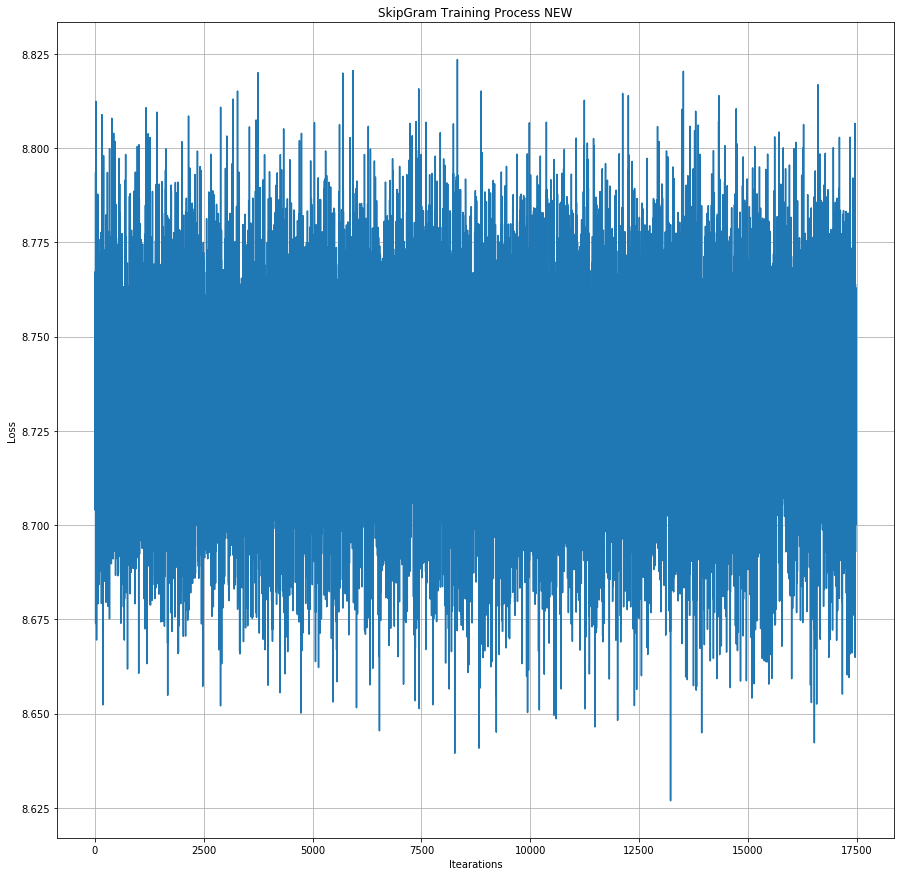

In [201]:
plt.title('SkipGram Training Process NEW')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [214]:
# проверка, что хоть что-то выучилось
np.mean(losses[-1000:])

8.733450582504272

In [267]:
new_embedding_matrix = new_model.in_embedding.weight.detach()

In [268]:
new_vocab = new_word2index.keys()

In [269]:
new_df = df.copy()

In [270]:
new_emb_scores = []
for idx, row in new_df.iterrows():
    if row['# Word1'] in new_vocab and row['Word2'] in new_vocab:
        sim = cos_sim(new_embedding_matrix, new_word2index, row['# Word1'], row['Word2'])
        new_emb_scores.append(sim)
    else:
        new_df.drop([idx], inplace=True)

In [271]:
new_df['NEW Embedding Score'] = new_emb_scores

In [272]:
new_df[['Normed NEW Embedding']] = scaler.fit_transform(new_df[['NEW Embedding Score']])

In [273]:
new_df.head(5)

,# Word1,Word2,Average Score,Normed Score,Embedding Score,Normed Embedding,NEW Embedding Score,Normed NEW Embedding
1,август,месяц,2.85,0.285,0.474598,0.830700,-0.280234,0.292204
3,автомобиль,гудок,1.85,0.185,-0.128106,0.398491,0.119309,0.623082
5,автомобиль,такси,4.15,0.415,-0.011401,0.482182,0.095017,0.602965
27,аргументировать,подтверждать,5.46,0.546,-0.109956,0.411507,0.180144,0.673462
47,бог,дух,4.08,0.408,-0.418648,0.190139,-0.073276,0.463594


In [277]:
mse_after = mean_squared_error(new_df['Normed Score'], new_df['Normed NEW Embedding'])
print(mse_before, mse_after)

0.18862689294612311 0.15556700762715311


In [278]:
mse_before - mse_after

0.03305988531897

Улучшилось! Хотя и всего на 0.03, и лосс больше 7.5, и выглядит странно. И ещё при таком подходе за размеров словаря сильно уменьшается и размер тестового датасета, что не хочень хорошо

Второй заход. Попробую оставить прежний корпус, чтобы не уменьшать тестовый датасет, но увеличу размерность эмбеддинга и количество эпох

In [279]:
EMBEDDING_DIM = 50

In [280]:
newer_model = SkipGram(vocab_size=len(word2index), embedding_dim=EMBEDDING_DIM)

In [281]:
epochs = 5

losses = []

for n_epoch in range(epochs):

    try:

        progress_bar = tqdm(total=len(dataset_loader.dataset), desc='Epoch {}'.format(n_epoch + 1))

        for x, y in dataset_loader:

            # CODE
            prediction = newer_model(x)
            
            loss = criterion(prediction, y) # CODE
            
            # CODE
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            
            progress_bar.set_postfix(loss=np.mean(losses[-100:]))

            progress_bar.update(x.shape[0])

        progress_bar.close()

    except KeyboardInterrupt:

        progress_bar.close()
        break

Epoch 5: 100%|██████████████████████████████████████████████████| 2983124/2983124 [21:45<00:00, 2285.06it/s, loss=9.64]


In [282]:
torch.save(newer_model, 'hw2_newer_model.pt')

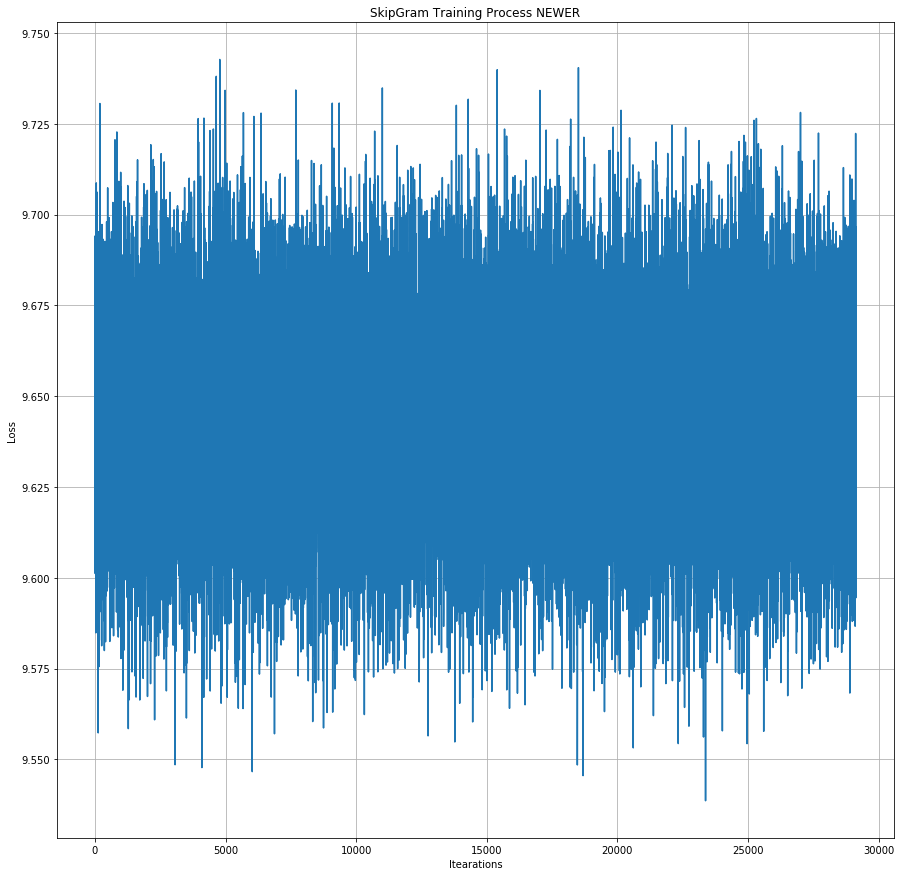

In [283]:
plt.title('SkipGram Training Process NEWER')
plt.xlabel('Itearations')
plt.ylabel('Loss')
plt.grid()
plt.plot(losses)

In [284]:
# проверка, что хоть что-то выучилось
np.mean(losses[-1000:])

9.642005999565125

In [285]:
newer_embedding_matrix = newer_model.in_embedding.weight.detach()

In [286]:
newer_emb_scores = []
for idx, row in df.iterrows():
    sim = cos_sim(newer_embedding_matrix, word2index, row['# Word1'], row['Word2'])
    newer_emb_scores.append(sim)

In [289]:
df['NEWER Embedding Score'] = newer_emb_scores

In [290]:
df[['Normed NEWER Embedding']] = scaler.fit_transform(df[['NEWER Embedding Score']])

In [291]:
df.head(5)

,# Word1,Word2,Average Score,Normed Score,Embedding Score,Normed Embedding,NEWER Embedding Score,Normed NEWER Embedding
1,август,месяц,2.85,0.285,0.474598,0.830700,0.293755,0.883011
3,автомобиль,гудок,1.85,0.185,-0.128106,0.398491,-0.167659,0.321186
5,автомобиль,такси,4.15,0.415,-0.011401,0.482182,0.054961,0.592252
7,автомобиль,велосипед,1.38,0.138,0.187274,0.624655,-0.000154,0.525143
9,автомобиль,мост,1.15,0.115,-0.185354,0.357438,-0.007710,0.515942


In [293]:
mse_second_try = mean_squared_error(df['Normed Score'], df['Normed NEWER Embedding'])
print(mse_before, mse_second_try)

0.18862689294612311 0.14434707559850468


In [294]:
mse_before - mse_second_try

0.04427981734761843

In [295]:
mse_after - mse_second_try

0.011219932028648433

Результат улучшился на 0.04 по сравнению с первым вариантом и на 0.01 по сравнению со вариантом с меньшим словарём

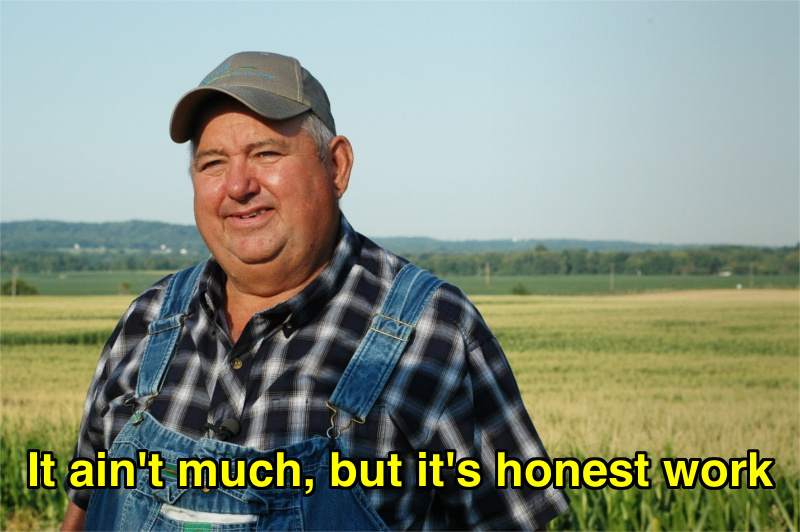

In [301]:
from IPython import display
display.Image('https://en.meming.world/images/en/b/be/But_It%27s_Honest_Work.jpg', width = 300, height = 150)